This notebook contains an implementation of untangled  conditional AAE. In this model, class labels are used as input for decoder and discriminator. The quality of untangling is tested by training a classifier on latent space. Then cAAE is used for style transfer.

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
# import dataloader and dataset

from torch.utils.data import Dataset, DataLoader

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import seaborn as sns
import sklearn
import imblearn
import matplotlib.pyplot as plt
import time
import os
import sklearn.metrics as m
import xgboost as xgbxgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import logging
import warnings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%matplotlib inline

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class Cicids2017Dataset:

    def __init__(self, __data_folder):
        self._data_folder = __data_folder
        self._data = None
        self._labels = None
        self._train_data = None
        self._test_data = None
        self._train_labels = None
        self._test_labels = None
        self._label_index_to_name = None

    def _load_dataset(self, __dataset_path):
        if not os.path.exists(__dataset_path):
            print('Dataset file not found')
            return False
        self._data = pd.read_csv(__dataset_path)
        self._labels = self._data[' Label'].unique()
        return True

    def load_base_dataset(self):
        return self._load_dataset(os.path.join(self._data_folder, "dataset_base.csv"))

    def load_preprocessed_dataset(self):
        return self._load_dataset(os.path.join(self._data_folder, "cAAE_input.csv"))

    def load_preprocessed_smote_dataset(self):
        return self._load_dataset(os.path.join(self._data_folder, "dataset_preprocessed_smote.csv"))

    def _transform_labels_to_one_hot(self):
        if self._train_labels is None or self._test_labels is None:
            return
        self._train_labels = pd.get_dummies(self._train_labels).astype('float64')
        self._test_labels = pd.get_dummies(self._test_labels).astype('float64')
        self._label_index_to_name = self._train_labels.columns

    def prepare_train_test_data(self, __test_size = 0.1, __random_state = 42):
        self._train_data, self._test_data = train_test_split(self._data, test_size=__test_size, random_state=__random_state)
        self._train_labels = self._train_data[' Label']
        self._test_labels = self._test_data[' Label']
        self._transform_labels_to_one_hot()
        self._train_data.drop([' Label'], axis=1, inplace=True)
        self._test_data.drop([' Label'], axis=1, inplace=True)

    def free_internal_memory(self):
        del self._data
        self._data = None

    def get_labels(self):
        return self._labels

    def drop_label(self, label_to_drop):
        self._data = self._data[self._data[" Label"] != label_to_drop]

In [6]:
dataset = Cicids2017Dataset('dataset')

In [7]:
dataset.load_preprocessed_dataset()

True

In [8]:
dataset._data[" Label"].value_counts()

DDoS                          100000
PortScan                      100000
DoS Hulk                      100000
DoS GoldenEye                  10293
FTP-Patator                     7935
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1956
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name:  Label, dtype: int64

In [ ]:
dataset.drop_label("BENIGN")

In [ ]:
# loop through each label in dataset._data and if each label exceeds 10,000, then remove the excess

for label in dataset.get_labels():
    print(f"Fixing label {label} ...")
    label_count, rows_to_drop = 0, []
    for i in dataset._data[" Label"].index:
        if dataset._data[" Label"][i] == label:
            label_count += 1
            if label_count > 10000:
                rows_to_drop.append(i)
    dataset._data.drop(rows_to_drop, inplace=True)
    print(f"Fixed label {label} ...")

Fixing label BENIGN ...
Fixed label BENIGN ...
Fixing label DDoS ...
Fixed label DDoS ...
Fixing label PortScan ...
Fixed label PortScan ...
Fixing label Bot ...
Fixed label Bot ...
Fixing label Infiltration ...
Fixed label Infiltration ...
Fixing label Web Attack � Brute Force ...
Fixed label Web Attack � Brute Force ...
Fixing label Web Attack � XSS ...
Fixed label Web Attack � XSS ...
Fixing label Web Attack � Sql Injection ...
Fixed label Web Attack � Sql Injection ...
Fixing label FTP-Patator ...
Fixed label FTP-Patator ...
Fixing label SSH-Patator ...
Fixed label SSH-Patator ...
Fixing label DoS slowloris ...
Fixed label DoS slowloris ...
Fixing label DoS Slowhttptest ...
Fixed label DoS Slowhttptest ...
Fixing label DoS Hulk ...
Fixed label DoS Hulk ...
Fixing label DoS GoldenEye ...
Fixed label DoS GoldenEye ...
Fixing label Heartbleed ...
Fixed label Heartbleed ...


In [ ]:
dataset._data[" Label"].value_counts()

 Label
DDoS                          10000
PortScan                      10000
DoS Hulk                      10000
DoS GoldenEye                 10000
FTP-Patator                    7935
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Bot                            1956
Web Attack � Brute Force       1507
Web Attack � XSS                652
Infiltration                     36
Web Attack � Sql Injection       21
Heartbleed                       11
Name: count, dtype: int64

In [ ]:
dataset._data.to_csv('cAAE_input.csv', index=False)

In [9]:
class CDataset:
    def __init__(self, __data_in, __data_out):
        assert len(__data_in) == len(__data_out)
        self._data_in = __data_in.to_numpy()
        self._data_out = __data_out.to_numpy()

    def __len__(self):
        return len(self._data_in)

    def __getitem__(self, __index):
        return torch.from_numpy(self._data_in[__index]).to(torch.float32), torch.from_numpy(self._data_out[__index]).to(torch.float32)


In [10]:
dataset.prepare_train_test_data()

In [11]:
dataset._train_labels.columns.size, dataset._test_labels.columns.size

(14, 14)

In [12]:

def to_onehot(tensor, num_classes):
    if not isinstance(tensor, torch.Tensor):
        raise ValueError(f"Input must be a torch.Tensor, but got {type(tensor)}")

    if tensor.dim() != 1:
        raise ValueError(f"Input tensor must be 1-dimensional, but got {tensor.dim()} dimensions")

    if not isinstance(num_classes, int) or num_classes <= 0:
        raise ValueError("Number1 of classes must be a positive integer")

    tensor = tensor.long()  # Convert to long tensor if not already
    onehot = torch.zeros(tensor.size(0), num_classes)
    onehot.scatter_(1, tensor.view(-1, 1), 1)

    return onehot


In [13]:
param_input_shape = 70
param_layers_size = (1024, 1024)
param_ld_size = 2
param_num_classes = dataset._test_labels.columns.size
param_ae_loss_fn = F.binary_cross_entropy_with_logits
param_batch_size = 250

# train_loader, valid_loader, test_loader = mnist(batch_size=param_batch_size, valid=10000, transform=mnist_0_1)
train_loader = DataLoader(CDataset(dataset._train_data, dataset._train_labels), batch_size=param_batch_size, shuffle=True)
test_loader = DataLoader(CDataset(dataset._test_data, dataset._test_labels), batch_size=param_batch_size, shuffle=False)
valid_loader = DataLoader(CDataset(dataset._test_data, dataset._test_labels), batch_size=param_batch_size, shuffle=False)

# True / fake labels.
batch_zeros = torch.zeros((param_batch_size, 1)).to(device)
batch_ones = torch.ones((param_batch_size, 1)).to(device)
# For sampling from true multivariate normal distribution.
distribution = torch.distributions.MultivariateNormal(torch.zeros(param_ld_size), torch.eye(param_ld_size))

# Fixed inputs for tests.
fixed_z = distribution.sample((param_num_classes, )).repeat((1,param_num_classes)).view(-1, param_ld_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(param_num_classes))).repeat((param_num_classes)), param_num_classes).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = fixed_label[:100].to(device)

In [14]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(param_input_shape, param_layers_size[0])
        self.do1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(param_layers_size[0], param_layers_size[1])
        self.do2 = nn.Dropout(0.3)
        self.z = nn.Linear(param_layers_size[1], param_ld_size)

    def forward(self, x):
        x = x.view(-1, param_input_shape)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        z = self.z(x)
        return z

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(param_ld_size+param_num_classes, param_layers_size[0])
        self.do1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(param_layers_size[0], param_layers_size[1])
        self.do2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(param_layers_size[1], param_input_shape)

    def forward(self, x, target):
        x = torch.cat([x, target], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Discriminator(nn.Module):
    # Distinguishes z sample from N(0, 1), makes z and labels independent.
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(param_ld_size+param_num_classes, param_layers_size[0])
        self.do1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(param_layers_size[0], param_layers_size[1])
        self.do2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(param_layers_size[1], 1)

    def forward(self, x, target):
        x = torch.cat([x, target], dim=1)
        x = torch.relu(self.do1(self.fc1(x)))
        x = torch.relu(self.do2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [15]:
E = Encoder()
# Encoder optimizer.
E_opt = optim.Adam(E.parameters(), lr=1e-4)
E.to(device)
D = Decoder()
# Decoder optimizer.
D_opt = optim.Adam(D.parameters(), lr=1e-4)
D.to(device)
DC = Discriminator()
# Discriminator optimizer.
DC_opt = optim.Adam(DC.parameters(), lr=1e-4)
DC.to(device)

train_log = {"AE": [], "E": [], "DC": []}
test_log = {"AE": [], "E": [], "DC": []}

In [16]:
def train(epoch, E, D, DC, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        if target.shape[0] != param_batch_size:
                continue
        data = data.to(device)
        # target = to_onehot(target, 10, device)
        target = target.to(device)
        rand_target = to_onehot(torch.from_numpy(np.random.randint(0, param_num_classes, (param_batch_size))), param_num_classes).to(device)

        # Discriminator training.
        E.zero_grad()
        D.zero_grad()
        DC.zero_grad()


        fake_z = DC(E(data), target)
        true_z = DC(distribution.sample((param_batch_size, )).to(device), rand_target)
        fake_loss = F.binary_cross_entropy_with_logits(fake_z, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_z, batch_ones)

        DC_loss = 0.5*(fake_loss + true_loss)
        DC_loss.backward()
        DC_opt.step()

        # Autoencoder training.
        E.zero_grad()
        D.zero_grad()
        DC.zero_grad()

        z = E(data)
        recon = D(z, target)
        reconstruction_loss = param_ae_loss_fn(recon, data.view(-1, param_input_shape))

        fake_z = DC(z, target)
        regularization_loss = F.binary_cross_entropy_with_logits(fake_z, batch_ones)

        AE_loss = reconstruction_loss + regularization_loss

        AE_loss.backward()
        D_opt.step()
        E_opt.step()

        if batch_idx % 100 == 0:
            line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = "AE: {:.4f}, E: {:.4f}, DC: {:.4f}".format(reconstruction_loss.item(), regularization_loss.item(), DC_loss.item())
            print(line + losses)

    else:
        batch_idx += 1
        line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = "AE: {:.4f}, E: {:.4f}, DC:{:.4f}".format(reconstruction_loss.item(), regularization_loss.item(), DC_loss.item())
        print(line + losses)
        log["AE"].append(reconstruction_loss.item())
        log["E"].append(regularization_loss.item())
        log["DC"].append(DC_loss.item())

In [17]:
def test(E, D, DC, loader, epoch, log=None):
    test_size = len(loader)
    reconstruction_loss = 0.
    regularization_loss = 0.
    DC_loss = 0.
    test_loss = {"AE": 0., "E": 0., "DC": 0}
    with torch.no_grad():
        for data, target in loader:
            if target.shape[0] != param_batch_size:
                continue
            data = data.to(device)
            # target = to_onehot(target, 10, device)
            target = target.to(device)
            rand_target = to_onehot( torch.from_numpy(np.random.randint(0, param_num_classes, (param_batch_size))), param_num_classes).to(device)

            z = E(data)
            recon = D(z, target)
            reconstruction_loss += param_ae_loss_fn(recon, data.view(-1, param_input_shape)).item()

            fake_z = DC(z, target)
            true_z = DC(distribution.sample((param_batch_size, )).to(device), rand_target)
            fake_loss = F.binary_cross_entropy_with_logits(fake_z, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_z, batch_ones).item()
            DC_loss += 0.5*(fake_loss + true_loss)

            regularization_loss += F.binary_cross_entropy_with_logits(fake_z, batch_ones).item()

    reconstruction_loss /= test_size
    regularization_loss /= test_size
    DC_loss /= test_size

    report = "Test losses. AE: {:.4f}, E: {:.4f}, DC: {:.4f}\n".format(reconstruction_loss, regularization_loss, DC_loss)
    print(report)
    if log is not None:
        log["AE"].append(reconstruction_loss)
        log["E"].append(regularization_loss)
        log["DC"].append(DC_loss)

In [18]:
for epoch in range(1, 301):
    E.train()
    D.train()
    DC.train()
    train(epoch, E, D, DC, train_log)
    E.eval()
    D.eval()
    DC.eval()
    test(E, D, DC, valid_loader, epoch, test_log)

Train Epoch: 1 [0/305642 (0%)]	Losses AE: 0.6937, E: 0.6979, DC: 0.6972
Train Epoch: 1 [25000/305642 (8%)]	Losses AE: -19.3792, E: 5.0187, DC: 0.4343
Train Epoch: 1 [50000/305642 (16%)]	Losses AE: -8324.6719, E: 126.1155, DC: 0.0298
Train Epoch: 1 [75000/305642 (25%)]	Losses AE: -159533.0000, E: 1535.5619, DC: 0.0077
Train Epoch: 1 [100000/305642 (33%)]	Losses AE: -1543003.1250, E: 4441.2461, DC: 0.0037
Train Epoch: 1 [125000/305642 (41%)]	Losses AE: -6529381.0000, E: 9339.2041, DC: 0.0022
Train Epoch: 1 [150000/305642 (49%)]	Losses AE: -25199648.0000, E: 17164.8867, DC: 0.0025
Train Epoch: 1 [175000/305642 (57%)]	Losses AE: -50565084.0000, E: 57791.6016, DC: 0.0075
Train Epoch: 1 [200000/305642 (65%)]	Losses AE: -132810328.0000, E: 86494.0547, DC: 0.0018
Train Epoch: 1 [225000/305642 (74%)]	Losses AE: -273515296.0000, E: 129537.8281, DC: 0.0014
Train Epoch: 1 [250000/305642 (82%)]	Losses AE: -518336160.0000, E: 186516.6094, DC: 0.0044
Train Epoch: 1 [275000/305642 (90%)]	Losses AE: -8

KeyboardInterrupt: ignored

Losses plots. The encoder and discriminator converged after about 120 epochs of this model training. After that the reconstruction loss decreased.

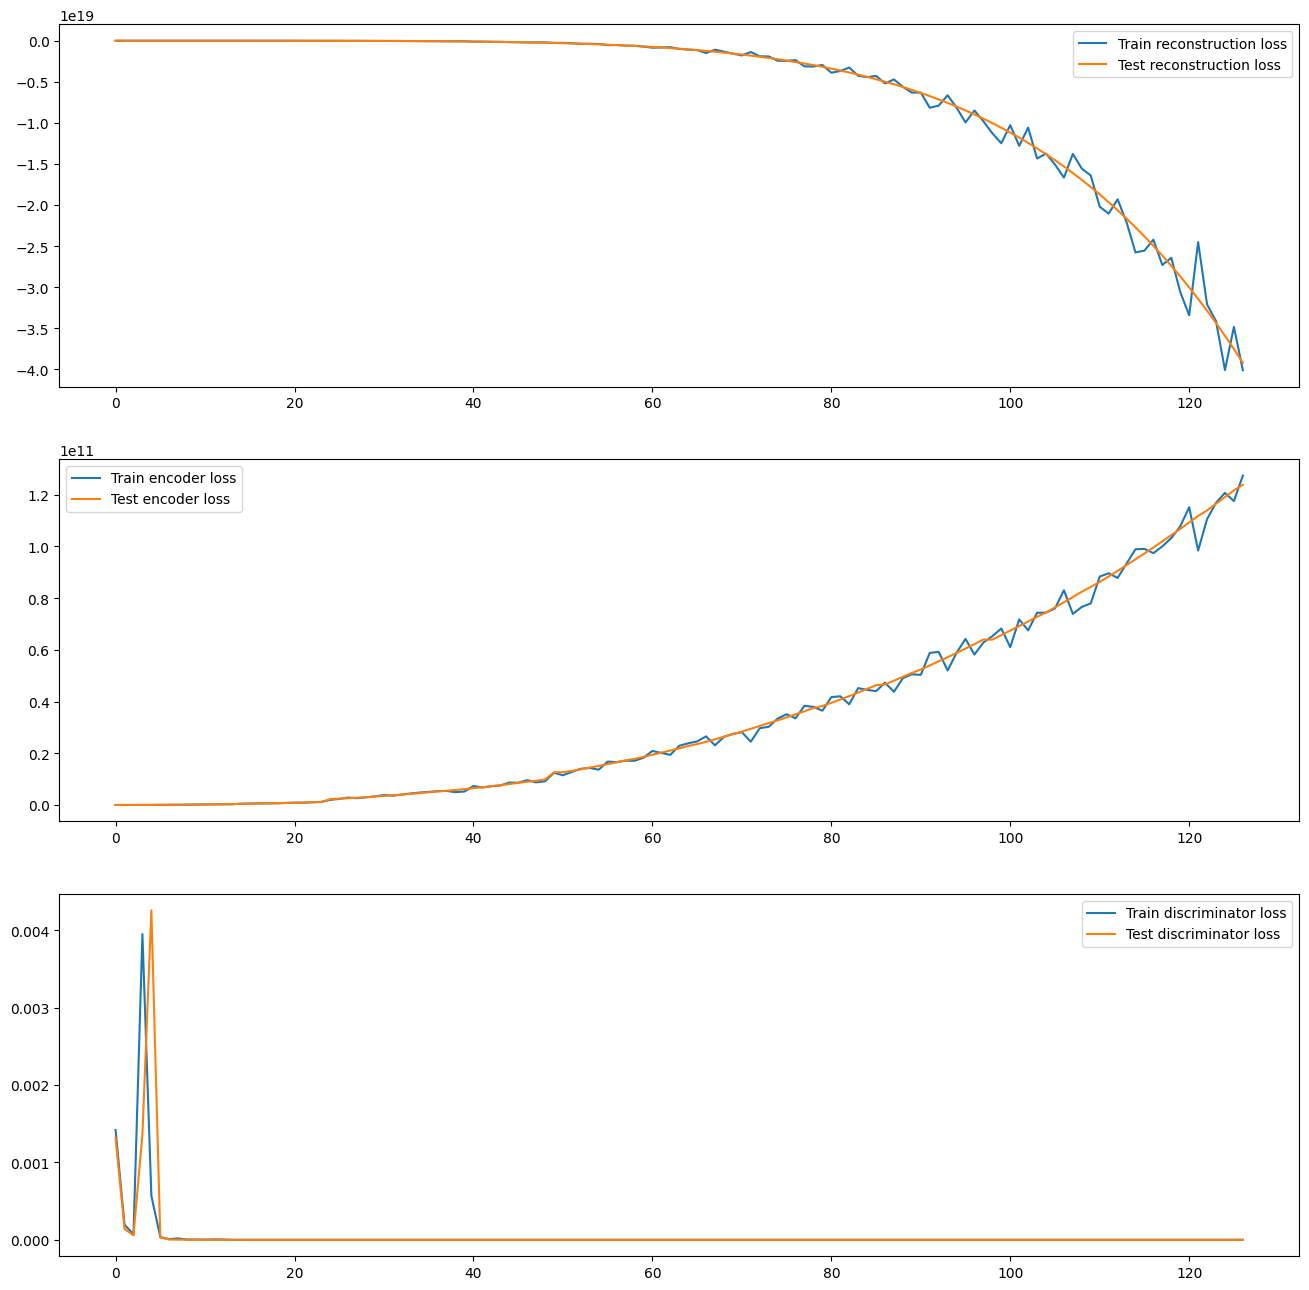

In [19]:
plt.figure(figsize=(16, 16))
plt.subplot(3, 1, 1)
plt.plot(train_log["AE"], label="Train reconstruction loss")
plt.plot(test_log["AE"], label="Test reconstruction loss")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(train_log["E"], label="Train encoder loss")
plt.plot(test_log["E"], label="Test encoder loss")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(train_log["DC"], label="Train discriminator loss")
plt.plot(test_log["DC"], label="Test discriminator loss")
plt.legend()
plt.show()

In [20]:
dataset._train_labels.value_counts()

Bot  DDoS  DoS GoldenEye  DoS Hulk  DoS Slowhttptest  DoS slowloris  FTP-Patator  Heartbleed  Infiltration  PortScan  SSH-Patator  Web Attack � Brute Force  Web Attack � Sql Injection  Web Attack � XSS
0.0  1.0   0.0            0.0       0.0               0.0            0.0          0.0         0.0           0.0       0.0          0.0                       0.0                         0.0                 90027
     0.0   0.0            0.0       0.0               0.0            0.0          0.0         0.0           1.0       0.0          0.0                       0.0                         0.0                 89999
                          1.0       0.0               0.0            0.0          0.0         0.0           0.0       0.0          0.0                       0.0                         0.0                 89913
           1.0            0.0       0.0               0.0            0.0          0.0         0.0           0.0       0.0          0.0                       0.0     

In [32]:
tot = 230000
labels, res = [], []
for i in range(14):
    target = torch.Tensor([0] * 14)
    target[i] = 1
    # make target 100x14 with all rows the same
    target = target.repeat(230, 1)
    tmp = D(torch.Tensor([[0, 0]]).to(device), torch.Tensor([[1] + [0] * 13]).to(device)).cpu().detach().numpy()
    for j in range(1000):
        # a latent vector of size 2
        z = torch.randn(230, 2).to(device)
        target = target.to(device)
        # tmp.concat(D(z, target).cpu().detach().numpy())
        tmp = np.concatenate((tmp, D(z, target).cpu().detach().numpy()))
    res.append(tmp)
res = np.stack(res).reshape((tot + 1) * 14, 70)
labels = np.array([[i for _ in range(tot + 1)] for i in range(14)]).reshape(-1)

In [33]:
res.shape

(3220014, 70)

In [40]:
df = pd.DataFrame(res, columns=dataset._train_data.columns)

In [42]:
df[" Label"] = labels

In [44]:
df[" Label"].value_counts()

0     230001
1     230001
2     230001
3     230001
4     230001
5     230001
6     230001
7     230001
8     230001
9     230001
10    230001
11    230001
12    230001
13    230001
Name:  Label, dtype: int64

In [45]:
df.to_csv("aaee_generated.csv", index=False)

# Unnecessary

Charts of generated images. First one contains original images from test set, second shows their reconstructions by model. Third one displays generations from samples of normal distribution as latent input to decoder and range of class labels.

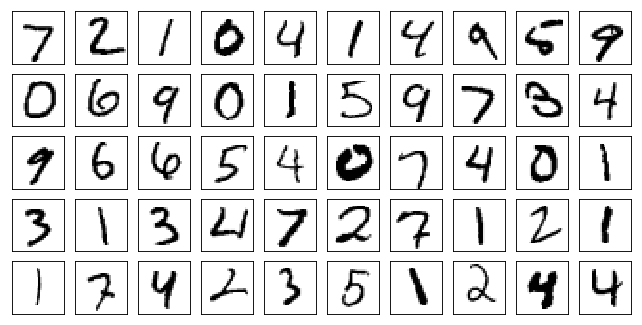

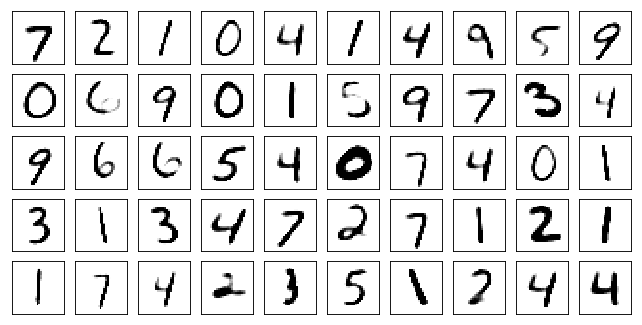

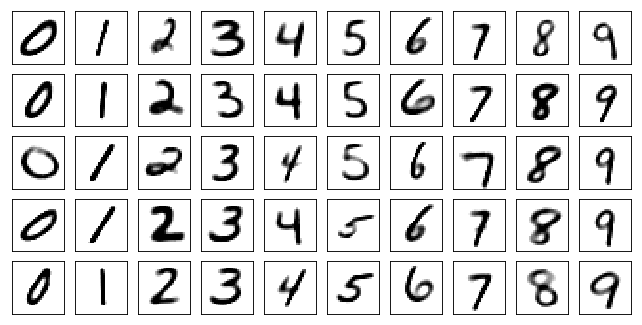

In [ ]:
data, target = next(iter(test_loader))
data = data[:50].to(device)
target = to_onehot(target[:50], 10, device)
output = D(E(data), target)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
decoded = D(distribution.sample((param_batch_size, ))[:50].to(device), to_onehot(torch.tensor(list(range(10))).repeat((10)), 10)[:50].to(device))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

plot_mnist(data.data.cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(dec_to_plot, (5, 10))

Latent space map for "3"s.

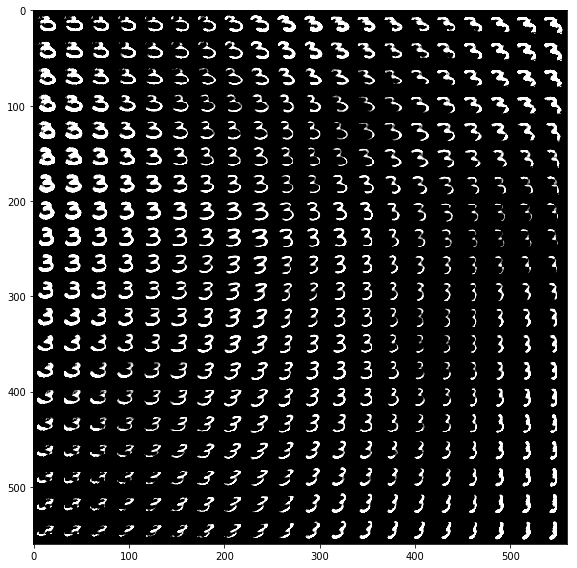

In [ ]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        d = np.zeros([1,param_ld_size],dtype="float32")
        z_mu = np.array([[xi, yi]])
        d[0,:2] = z_mu
        x_mean = D(torch.Tensor(d).to(device), torch.Tensor([[0,0,0,1,0,0,0,0,0,0]]).to(device))
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean.cpu().detach()[0].reshape(28, 28)

plt.figure(figsize=(8, 8))
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation="none",cmap=plt.get_cmap("gray"))
plt.tight_layout()

Generation from fixed samples and labels.

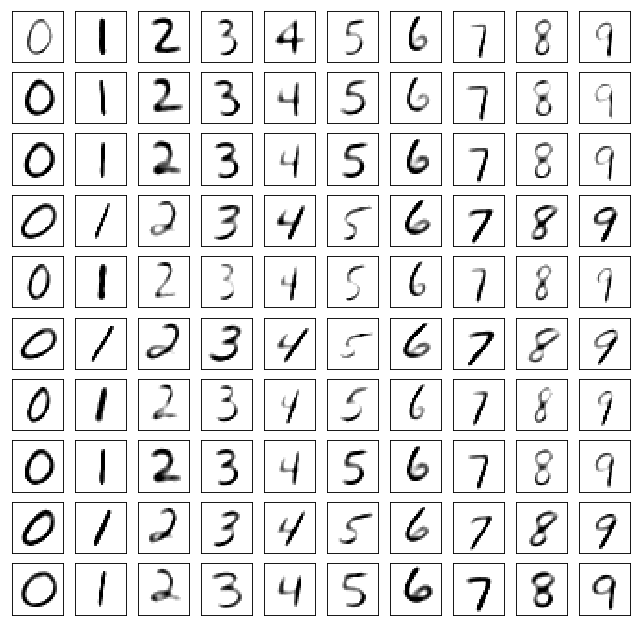

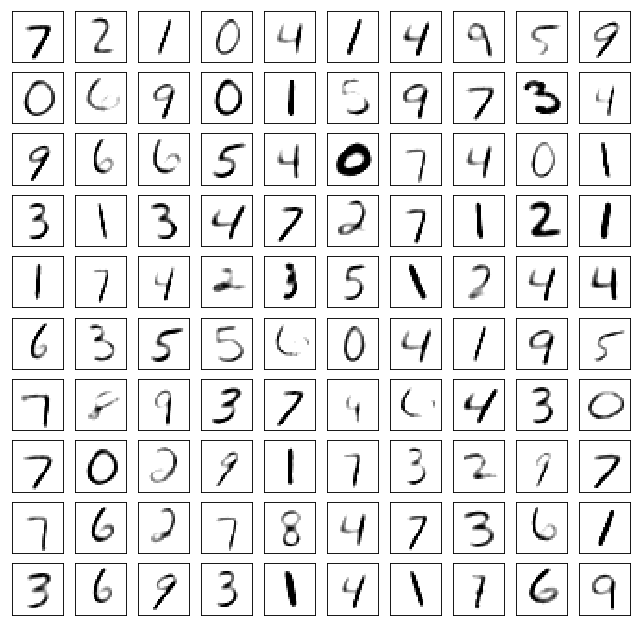

In [ ]:
fixed_gen = ((D(fixed_z, fixed_z_label))*0.5).clamp(0, 1).cpu().data.numpy().reshape(100, 1, 28, 28)
plot_mnist(fixed_gen, (10, 10))
fixed_reconstruction = ((D(E(fixed_data), fixed_label))*0.5).clamp(0, 1).cpu().data.numpy().reshape(100, 1, 28, 28)
plot_mnist(fixed_reconstruction, (10, 10))

Classifier for testing latent space for containing information about classes.

In [ ]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False,
                 last_fn=None, first_fn=None, device=device):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        if first_fn is not None:
            layers.append(first_fn)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn)
        else:
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)

    def forward(self, x, y=None):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        if y is not None:
            x = torch.cat([x, y], dim=1)
        return self.model(x)

In [ ]:
def train_cla(epoch, by_latent=False, log_interval=200):
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        Cla_opt.zero_grad()

        if by_latent:
            latent = E(data)
            output = Cla(latent)
        else:
            output = Cla(data)

        loss = F.cross_entropy(output, target)
        loss.backward()
        Cla_opt.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [ ]:
def test_cla(loss_vector, accuracy_vector, by_latent=False):
    val_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        if by_latent:
            latent = E(data)
            output = Cla(latent)
        else:
            output = Cla(data)
        val_loss += F.cross_entropy(output, target).data.item()
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(test_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_vector.append(accuracy)

    print("\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        val_loss, correct, len(test_loader.dataset), accuracy))

Training classifier to extract information about classes from latent representation created by encoder. Maximum achieved accuracy was 13%, which is almost a random guess from 10 classes (10%). That means that almost all class information was removed from latent space.

In [ ]:
Cla = FullyConnected([2, 256, 512, 256, 10], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)
Cla_opt = optim.Adam(Cla.parameters(), lr=1e-4)

lossv, accv = [], []
E.eval()
D.eval()
DC.eval()
for epoch in range(1, 101):
    Cla.train()
    train_cla(epoch, by_latent=True)
    Cla.eval()
    test_cla(lossv, accv, by_latent=True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309657

Validation set: Average loss: 2.2997, Accuracy: 1199/10000 (12%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.309205

Validation set: Average loss: 2.2985, Accuracy: 1210/10000 (12%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.305399

Validation set: Average loss: 2.2980, Accuracy: 1205/10000 (12%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.307346

Validation set: Average loss: 2.2978, Accuracy: 1221/10000 (12%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.306986

Validation set: Average loss: 2.2974, Accuracy: 1207/10000 (12%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.299619

Validation set: Average loss: 2.2982, Accuracy: 1205/10000 (12%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 2.297787

Validation set: Average loss: 2.2983, Accuracy: 1238/10000 (12%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 2.298514

Validation set: Average loss: 2.2973, Accuracy: 1241/10000 (12%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 2.297102

Validation set: Average loss: 2.2977, Accuracy: 1219/10000

Loss and accuracy plots for classifier.

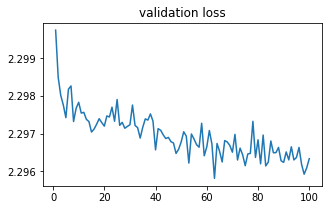

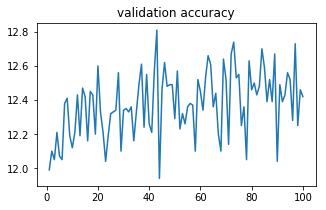

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,100+1), lossv)
plt.title("validation loss")

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,100+1), accv)
plt.title("validation accuracy");

Handwriting style transfer from a digit to others. First ten reference images were taken from test set, encoded to latent representation, and from those features each class image was generated. The transfer of the angle of inclination is clearly visible, there is some transfer of thickness. There are no transfers of curls (from the numbers 4 and 5). Perhaps, due to the fact that the number of hidden dimensions was chosen 2 (it was interesting to compress to the maximum, as well as draw a full two-dimensional map).

Style reference:


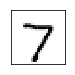

Generated:


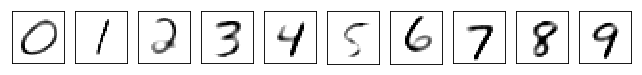

Style reference:


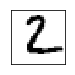

Generated:


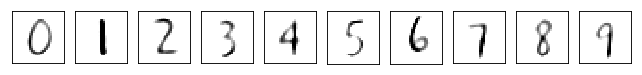

Style reference:


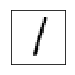

Generated:


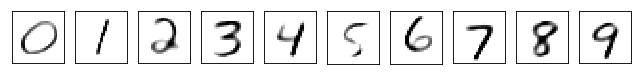

Style reference:


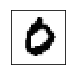

Generated:


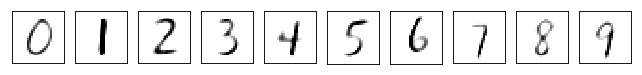

Style reference:


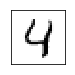

Generated:


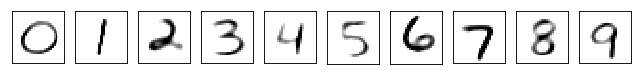

Style reference:


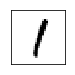

Generated:


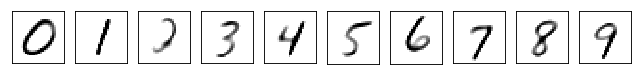

Style reference:


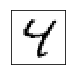

Generated:


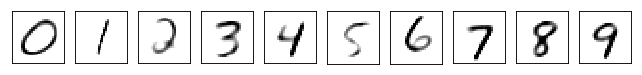

Style reference:


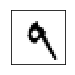

Generated:


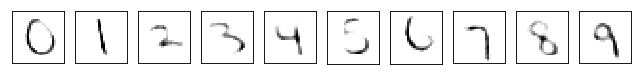

Style reference:


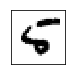

Generated:


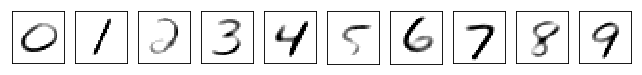

Style reference:


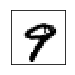

Generated:


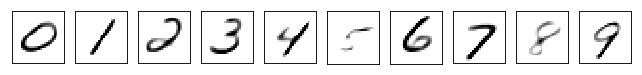

In [ ]:
style_imgs, style_targets = iter(test_loader).next()
for i in range(10):
    style_img = style_imgs[i]
    style_target = style_targets[i]
    print("Style reference:")
    plt.figure(figsize=(1, 1))
    plt.imshow(style_img.data.numpy().reshape(28,28), cmap="Greys")
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()

    with torch.no_grad():
        style_z = E(style_img.to(device))

    numbers_z = to_onehot(torch.tensor(list(range(10))), 10).to(device)

    style_gen = ((D(style_z.repeat((10,1)), numbers_z))*0.5).clamp(0, 1).cpu().data.numpy().reshape(10, 1, 28, 28)
    print("Generated:")
    plot_mnist(style_gen, (1, 10))